In [1]:
import os
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, AveragePooling2D, \
    GlobalAveragePooling2D,Dropout, Reshape, Concatenate
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
# # 设置数据集文件夹路径
dataset_dir = r"D:\桌面\Digital images of defective and good condition tyres"

In [3]:
# 定义图像大小
input_shape = (224, 224, 3)
batch_size = 16

#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)


In [4]:
#Data augmentation
train_datagen=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen=ImageDataGenerator(
    rescale=1./255)

In [5]:
# #Generate the train dataset, validation dataset and test dataset
train_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator=train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False,
    subset='validation')

test_generator=test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary' 
)

# 打印训练集和测试集的类别标签
print(train_generator.class_indices)
print(test_generator.class_indices)

Found 1486 images belonging to 2 classes.
Found 370 images belonging to 2 classes.
Found 1856 images belonging to 2 classes.
{'defective': 0, 'good': 1}
{'defective': 0, 'good': 1}


In [26]:
def vgg_block(x, filters, num_conv_layers):
    for _ in range(num_conv_layers):
        x = Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    return x

In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Multiply
from tensorflow.keras.layers import Dropout


def create_vgg16_model(input_shape):
    inputs = Input(shape=input_shape)

    x = vgg_block(inputs, 64, 2)
    x = vgg_block(x, 128, 2)
    x = vgg_block(x, 256, 3)
    x = vgg_block(x, 512, 3)
    x = vgg_block(x, 512, 3)

    # Adjust the output shape to match create_model2
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)

    return Model(inputs=inputs, outputs=x)


# 定义模型
input_shape = (224, 224, 3)
num_classes = 1
build_model_1 = create_vgg16_model(input_shape)

build_model_1.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_56 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_57 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_59 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

In [22]:
def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1)):
    # Shortcut
    shortcut = x
    
    # First convolutional layer
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Adjust the shortcut connection
    if stride != (1, 1):
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
    
    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [23]:
def create_resnet_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Initial convolutional layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Residual blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    
    x = residual_block(x, filters=128, stride=(2, 2))
    x = residual_block(x, filters=128)
    
    # Global average pooling
    x = GlobalAveragePooling2D()(x)
    
    return Model(inputs=inputs, outputs=x)

# 定义不同的具有注意力机制的模型
build_model_2 = create_resnet_model(input_shape)

build_model_2.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_46 (Conv2D)             (None, 112, 112, 64  9472        ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 112, 112, 64  256        ['conv2d_46[0][0]']              
 ormalization)                  )                                                           

 conv2d_55 (Conv2D)             (None, 56, 56, 128)  147584      ['activation_25[0][0]']          
                                                                                                  
 batch_normalization_26 (BatchN  (None, 56, 56, 128)  512        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_11 (Add)                   (None, 56, 56, 128)  0           ['batch_normalization_26[0][0]', 
                                                                  'activation_24[0][0]']          
                                                                                                  
 activation_26 (Activation)     (None, 56, 56, 128)  0           ['add_11[0][0]']                 
                                                                                                  
 global_av

In [30]:
from tensorflow.keras import Input
from tensorflow.keras.models import Model
import numpy as np

def create_ensemble_model(build_model_1, build_model_2, input_shape):
    # 定义输入层
    input_layer = Input(shape=input_shape)

    # 获取两个模型的输出
    output_model_1 = build_model_1(input_layer)
    output_model_2 = build_model_2(input_layer)

    # 合并两个模型的输出
    combined = concatenate([output_model_1, output_model_2])

    # 添加一个用于最终预测的全连接层
    output_layer = Dense(1, activation='sigmoid')(combined)

    # 创建组合模型
    ensemble_model = Model(inputs=input_layer, outputs=output_layer)

    return ensemble_model

In [31]:
# Define the input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 1

ensemble_model = create_ensemble_model(build_model_1, build_model_2, input_shape)
ensemble_model.summary()

# Compile and train the ensemble model
ensemble_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_5 (Functional)           (None, 128)          14780352    ['input_14[0][0]']               
                                                                                                  
 model_4 (Functional)           (None, 128)          685440      ['input_14[0][0]']               
                                                                                                  
 concatenate_3 (Concatenate)    (None, 256)          0           ['model_5[0][0]',          

In [32]:
# 训练集成模型
#Train the model
history=ensemble_model.fit(train_generator, batch_size=batch_size, epochs=5, validation_data=(validation_generator), verbose=1)

Epoch 1/5
93/93 [==============================] - 134s 1s/step - loss: 0.8565 - accuracy: 0.6157 - val_loss: 0.9086 - val_accuracy: 0.5486
Epoch 2/5
93/93 [==============================] - 111s 1s/step - loss: 0.6324 - accuracy: 0.6608 - val_loss: 0.6797 - val_accuracy: 0.6054
Epoch 3/5
93/93 [==============================] - 114s 1s/step - loss: 0.6262 - accuracy: 0.6622 - val_loss: 8.5825 - val_accuracy: 0.4459
Epoch 4/5
93/93 [==============================] - 114s 1s/step - loss: 0.6182 - accuracy: 0.6662 - val_loss: 1.2630 - val_accuracy: 0.6514
Epoch 5/5
93/93 [==============================] - 112s 1s/step - loss: 0.6182 - accuracy: 0.6615 - val_loss: 1.3564 - val_accuracy: 0.4459


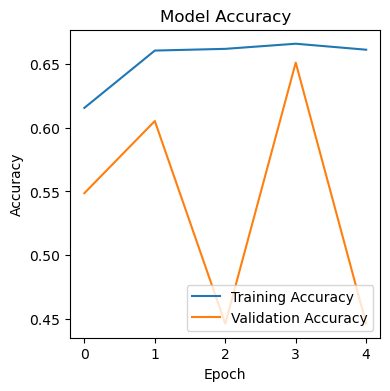

In [33]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(4,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')
plt.show()

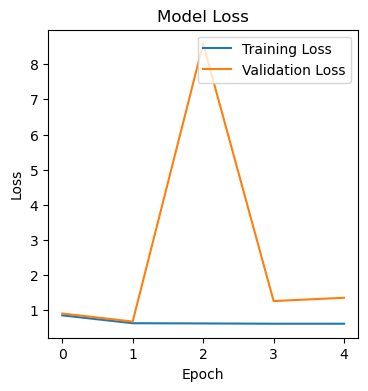

In [34]:
#Trainig loss and validation loss graph
plt.figure(figsize=(4,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')
plt.show()

In [35]:
# Evaluate the model on the testing dataset
test_loss, test_acc = ensemble_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

116/116 [==============================] - 100s 868ms/step - loss: 1.5617 - accuracy: 0.4461
Test loss: 1.5616658926010132
Test accuracy: 0.4461206793785095


In [36]:
#Compute confusion matrix
from sklearn.metrics import confusion_matrix

# Generate predictions for the test dataset
y_pred = ensemble_model.predict(test_generator)

116/116 [==============================] - 96s 828ms/step


Confusion Matrix:
[[   0 1028]
 [   0  828]]


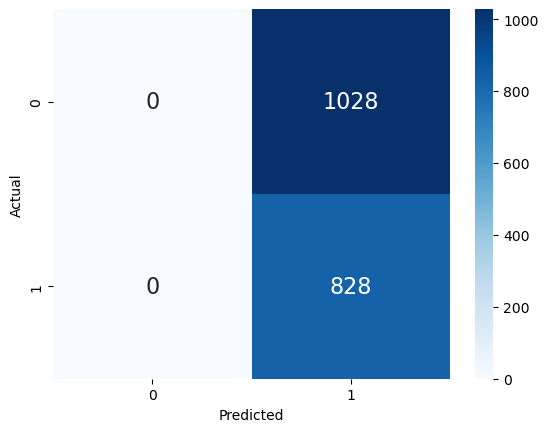

In [37]:
import numpy as np
import seaborn as sns

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = np.where(y_pred > threshold, 1, 0)

# 计算混淆矩阵
cm = confusion_matrix(test_generator.classes, y_pred_binary)

# 打印混淆矩阵
print("Confusion Matrix:")
print(cm)

# 使用Seaborn绘制热力图
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# 使用阈值0.5将概率值转换为二分类预测结果
threshold = 0.5
y_pred_binary = (y_pred > threshold).astype(int)

# 获取真实标签
y_true = test_generator.classes

# 计算精确度、召回率和F1得分
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.44612068965517243
Recall: 1.0
F1 Score: 0.61698956780924


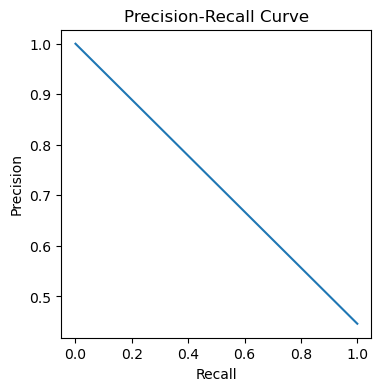

In [39]:
#compute precision-recall score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

#compute precision, recall(sensitivity), and threshold values
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_binary)

#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [40]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(y_true, y_pred_binary)

#compute the AUC score
roc_auc= auc(fpr, tpr)

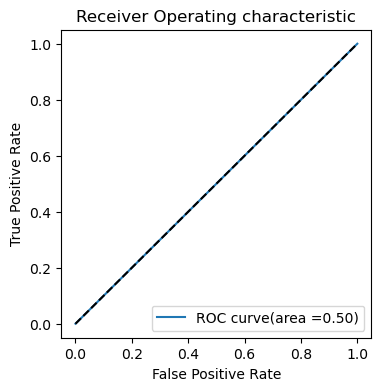

In [41]:
#plot the precision-recall curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [42]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 1.0
specificity: 0.0


In [43]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del ensemble_model

In [44]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()